In [5]:
import pandas as pd
import tarfile
import matplotlib.pyplot as plt

def read_tar(path, label):
    tar = tarfile.open(path, 'r:bz2')
    data = []
    for member in tar.getmembers():
        f = tar.extractfile(member)
        if f is not None:
            content = f.read().decode('latin-1')
            data.append({'text': content, 'label': label})
    return pd.DataFrame(data)

easy_ham = read_tar('datasets/20030228_easy_ham.tar.bz2', 0)
hard_ham = read_tar('datasets/20030228_hard_ham.tar.bz2', 0)
spam = read_tar('datasets/20030228_spam.tar.bz2', 1)
spam_2 = read_tar('datasets/20050311_spam_2.tar.bz2', 1)

df = pd.concat([easy_ham, hard_ham, spam, spam_2])

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, replace_urls=True, replace_numbers=True):
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.str.lower()
        if self.replace_urls:
            X = X.str.replace(r'https?://\S+|www\.\S+', 'url')
        if self.replace_numbers:
            X = X.str.replace(r'\d+', 'num')
        return X

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer

pipeline = Pipeline([
    ('text_transformer', TextTransformer()),
    ('count_vectorizer', CountVectorizer()),
    ('scaler', StandardScaler(with_mean=False)),
    ('model', None)
])

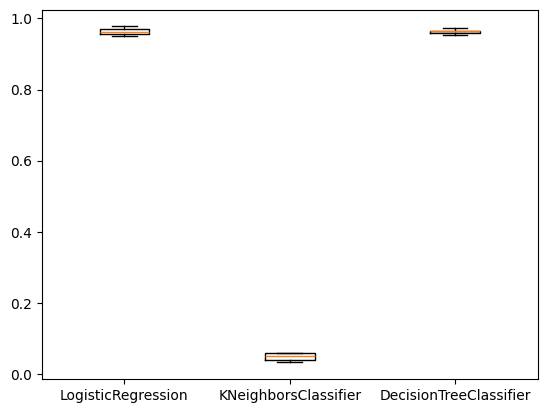

In [9]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

models = {
    'LogisticRegression': LogisticRegression(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier()
}

results = []

for model in models.values():
    pipeline.set_params(model=model)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='f1')
    results.append(scores)

plt.boxplot(results, labels=models.keys())
plt.show()

In [10]:
params = {
    'model__C': [0.1, 1, 10, 100],
    'model__penalty': ['l1', 'l2']
}

from sklearn.model_selection import GridSearchCV

pipeline.set_params(model=LogisticRegression())
grid = GridSearchCV(pipeline, params, cv=5, scoring='f1')
grid.fit(X_train, y_train)
print(grid.best_params_)

/Users/brandonmpark/Desktop/Coding/spam-classifier/.conda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/brandonmpark/Desktop/Coding/spam-classifier/.conda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/brandonmpark/Desktop/Coding/spam-classifier/.conda/lib/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^

{'model__C': 100, 'model__penalty': 'l2'}


In [20]:
y_pred = grid.predict(X_test)
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

[[546   4]
 [ 24 356]]
